In [1]:
import pandas as pd
from pathlib import Path
from cmi_dss_lib.utils.metrics import event_detection_ap

from cmi_dss_lib.utils.post_process import post_process_for_seg_v1
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Literal
chunk = 4
plt.style.use("ggplot")

RESULT_DIR = "../../../data/eda/predicted-fold0.npz"

In [2]:
data = np.load(RESULT_DIR)
keys = data["key"]
series_ids = list(set([str(k).split("_")[0] for k in keys]))
preds = data["pred"]
labels = data["label"]

gt_df = pd.read_csv(Path("../../../data/train-series-with-partid") / "train_events.csv")
gt_df = gt_df[gt_df["series_id"].isin(series_ids)].dropna().reset_index(drop=True)

In [3]:
def plot_random_sample(keys,preds, labels,list_id:list[str] ,df_submit,mode:Literal["all","onset","wakeup"],use_sleep:bool = True,num_chunks=5):
    # get series ids
    series_ids = np.array(list(map(lambda x: x.split("_")[0], keys)))
    #unique_series_ids = np.unique(series_ids)

    # get random series
    #random_series_ids = [unique_series_ids[3]]#np.random.choice(unique_series_ids, num_samples)
    #random_series_ids = np.random.choice(unique_series_ids, num_samples)

    for i, random_series_id in enumerate(list_id):
        # get random series
        series_idx = np.where(series_ids == random_series_id)[0]
        this_series_preds = preds[series_idx].reshape(-1, 3)
        this_series_labels = labels[series_idx].reshape(-1, 3)
        this_series_df = df_submit[df_submit["series_id"] == random_series_id].reset_index(drop = True)
        val_wakeup = this_series_df[this_series_df["event"] == "wakeup"]["step"].values
        val_onset = this_series_df[this_series_df["event"] == "onset"]["step"].values
        val_step = np.arange(1,preds[series_idx].reshape(-1,3).shape[0]+1)
        this_onset = np.isin(val_step,val_onset).astype(int)
        this_wakeup = np.isin(val_step,val_wakeup).astype(int)
        
        # split series
        this_series_preds = np.split(this_series_preds, num_chunks)
        this_series_wakeup = np.split(this_wakeup, num_chunks)
        this_series_onset = np.split(this_onset, num_chunks)
        this_series_labels = np.split(this_series_labels, num_chunks)

        fig, axs = plt.subplots(num_chunks, 1, figsize=(20, 5 * num_chunks))
        if num_chunks == 1:
            axs = [axs]
        for j in range(num_chunks):
            this_series_preds_chunk = this_series_preds[j]
            this_series_labels_chunk = this_series_labels[j]

            # get onset and wakeup idx
            onset_idx = np.nonzero(this_series_labels_chunk[:, 1])[0]*2
            wakeup_idx = np.nonzero(this_series_labels_chunk[:, 2])[0]*2

            pred_onset_idx = np.nonzero(this_series_onset[j])[0]
            pred_wakeup_idx = np.nonzero(this_series_wakeup[j])[0]
            

            if use_sleep:
                axs[j].plot(this_series_preds_chunk[:, 0], label="pred_sleep")
            if mode == "all" or mode == "onset":
                axs[j].plot(this_series_preds_chunk[:, 1], label="pred_onset")
                axs[j].vlines(pred_onset_idx, 0, 1, label="pred_label_onset", linestyles="dotted", color="C1")
                axs[j].vlines(onset_idx, 0, 1, label="actual_onset", linestyles="dashed", color="C1",linewidth=4)
            if mode == "all" or mode == "wakeup":
                axs[j].plot(this_series_preds_chunk[:, 2], label="pred_wakeup")
                axs[j].vlines(pred_wakeup_idx, 0, 1, label="pred_label_wakeup", linestyles="dotted", color="C4")
                axs[j].vlines(wakeup_idx, 0, 1, label="actual_wakeup", linestyles="dashed", color="C4",linewidth=4)

            axs[j].set_ylim(0, 1)
            axs[j].set_title(f"series_id: {random_series_id} chunk_id: {j}")
            axs[j].legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)

    plt.tight_layout()


In [4]:
df_submit = post_process_for_seg_v1(preds = preds[:,:,[0,1,2]] ,keys = keys,score_th=0.005,distance = 96,th_hour=6).to_pandas()

In [5]:
from tqdm import tqdm
sub_id = gt_df["series_id"].unique()
dict_result = {"series_id":[],"score":[]}
for s_id in tqdm(sub_id):
    dict_result["series_id"].append(s_id)
    dict_result["score"].append(event_detection_ap(solution=gt_df[gt_df["series_id"] == s_id],submission=df_submit[df_submit["series_id"] == s_id]))

  2%|▏         | 1/53 [00:00<00:06,  8.16it/s]

100%|██████████| 53/53 [00:05<00:00, 10.27it/s]


array([[<Axes: title={'center': 'score'}>]], dtype=object)

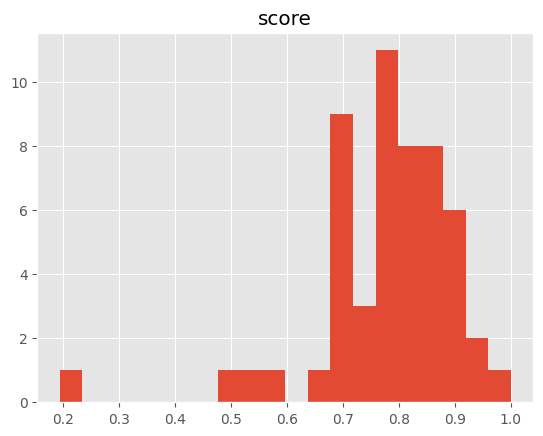

In [6]:
pd.DataFrame(dict_result).hist(bins = 20)

In [7]:
event_detection_ap(solution=gt_df,submission=df_submit)

0.7690547986102225

In [8]:
pd.DataFrame(dict_result).query("score <= 0.6")

,series_id,score
4,1f96b9668bdf,0.498343
7,280e08693c6d,0.582103
22,7476c0bd18d2,0.524111
39,b7fc34995d0f,0.194231


In [42]:

from tqdm import tqdm
sub_id = gt_df["series_id"].unique()
dict_result = {"series_id":[],"score":[]}
for s_id in tqdm(sub_id):
    dict_result["series_id"].append(s_id)
    dict_result["score"].append(event_detection_ap(solution=gt_df[gt_df["series_id"] == s_id],submission=df_submit[(df_submit["series_id"] == s_id) & (df_submit["sleep_score"] > 0.5)]))

100%|██████████| 53/53 [00:04<00:00, 11.58it/s]


array([[<Axes: title={'center': 'score'}>]], dtype=object)

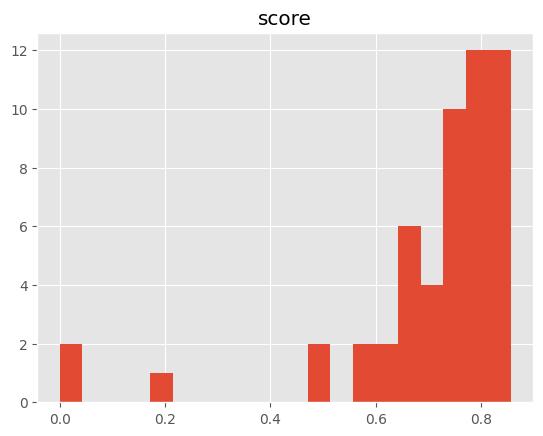

In [43]:

pd.DataFrame(dict_result).hist(bins = 20)

In [44]:

event_detection_ap(solution=gt_df,submission=df_submit[df_submit["sleep_score"] > 0.5])

0.7729047637382425

In [45]:
pd.DataFrame(dict_result).query("score <= 0.6")

,series_id,score
4,1f96b9668bdf,0.491914
7,280e08693c6d,0.579243
22,7476c0bd18d2,0.505000
33,a2b0a64ec9cf,0.000000
38,b750c8c1556c,0.595830
39,b7fc34995d0f,0.200728
43,c5365a55ebb7,0.000000


In [46]:
pd.DataFrame(dict_result).sort_values(by = ["score"])

,series_id,score
43,c5365a55ebb7,0.000000
33,a2b0a64ec9cf,0.000000
39,b7fc34995d0f,0.200728
4,1f96b9668bdf,0.491914
22,7476c0bd18d2,0.505000
7,280e08693c6d,0.579243
38,b750c8c1556c,0.595830
27,8b8b9e29171c,0.637072
41,bfa54bd26187,0.637583
44,c7b2155a4a47,0.646957


In [47]:
list_lowscore = pd.DataFrame(dict_result).query("score <= 0.5")["series_id"].to_list()

In [48]:
list_lowscore

['1f96b9668bdf', 'a2b0a64ec9cf', 'b7fc34995d0f', 'c5365a55ebb7']

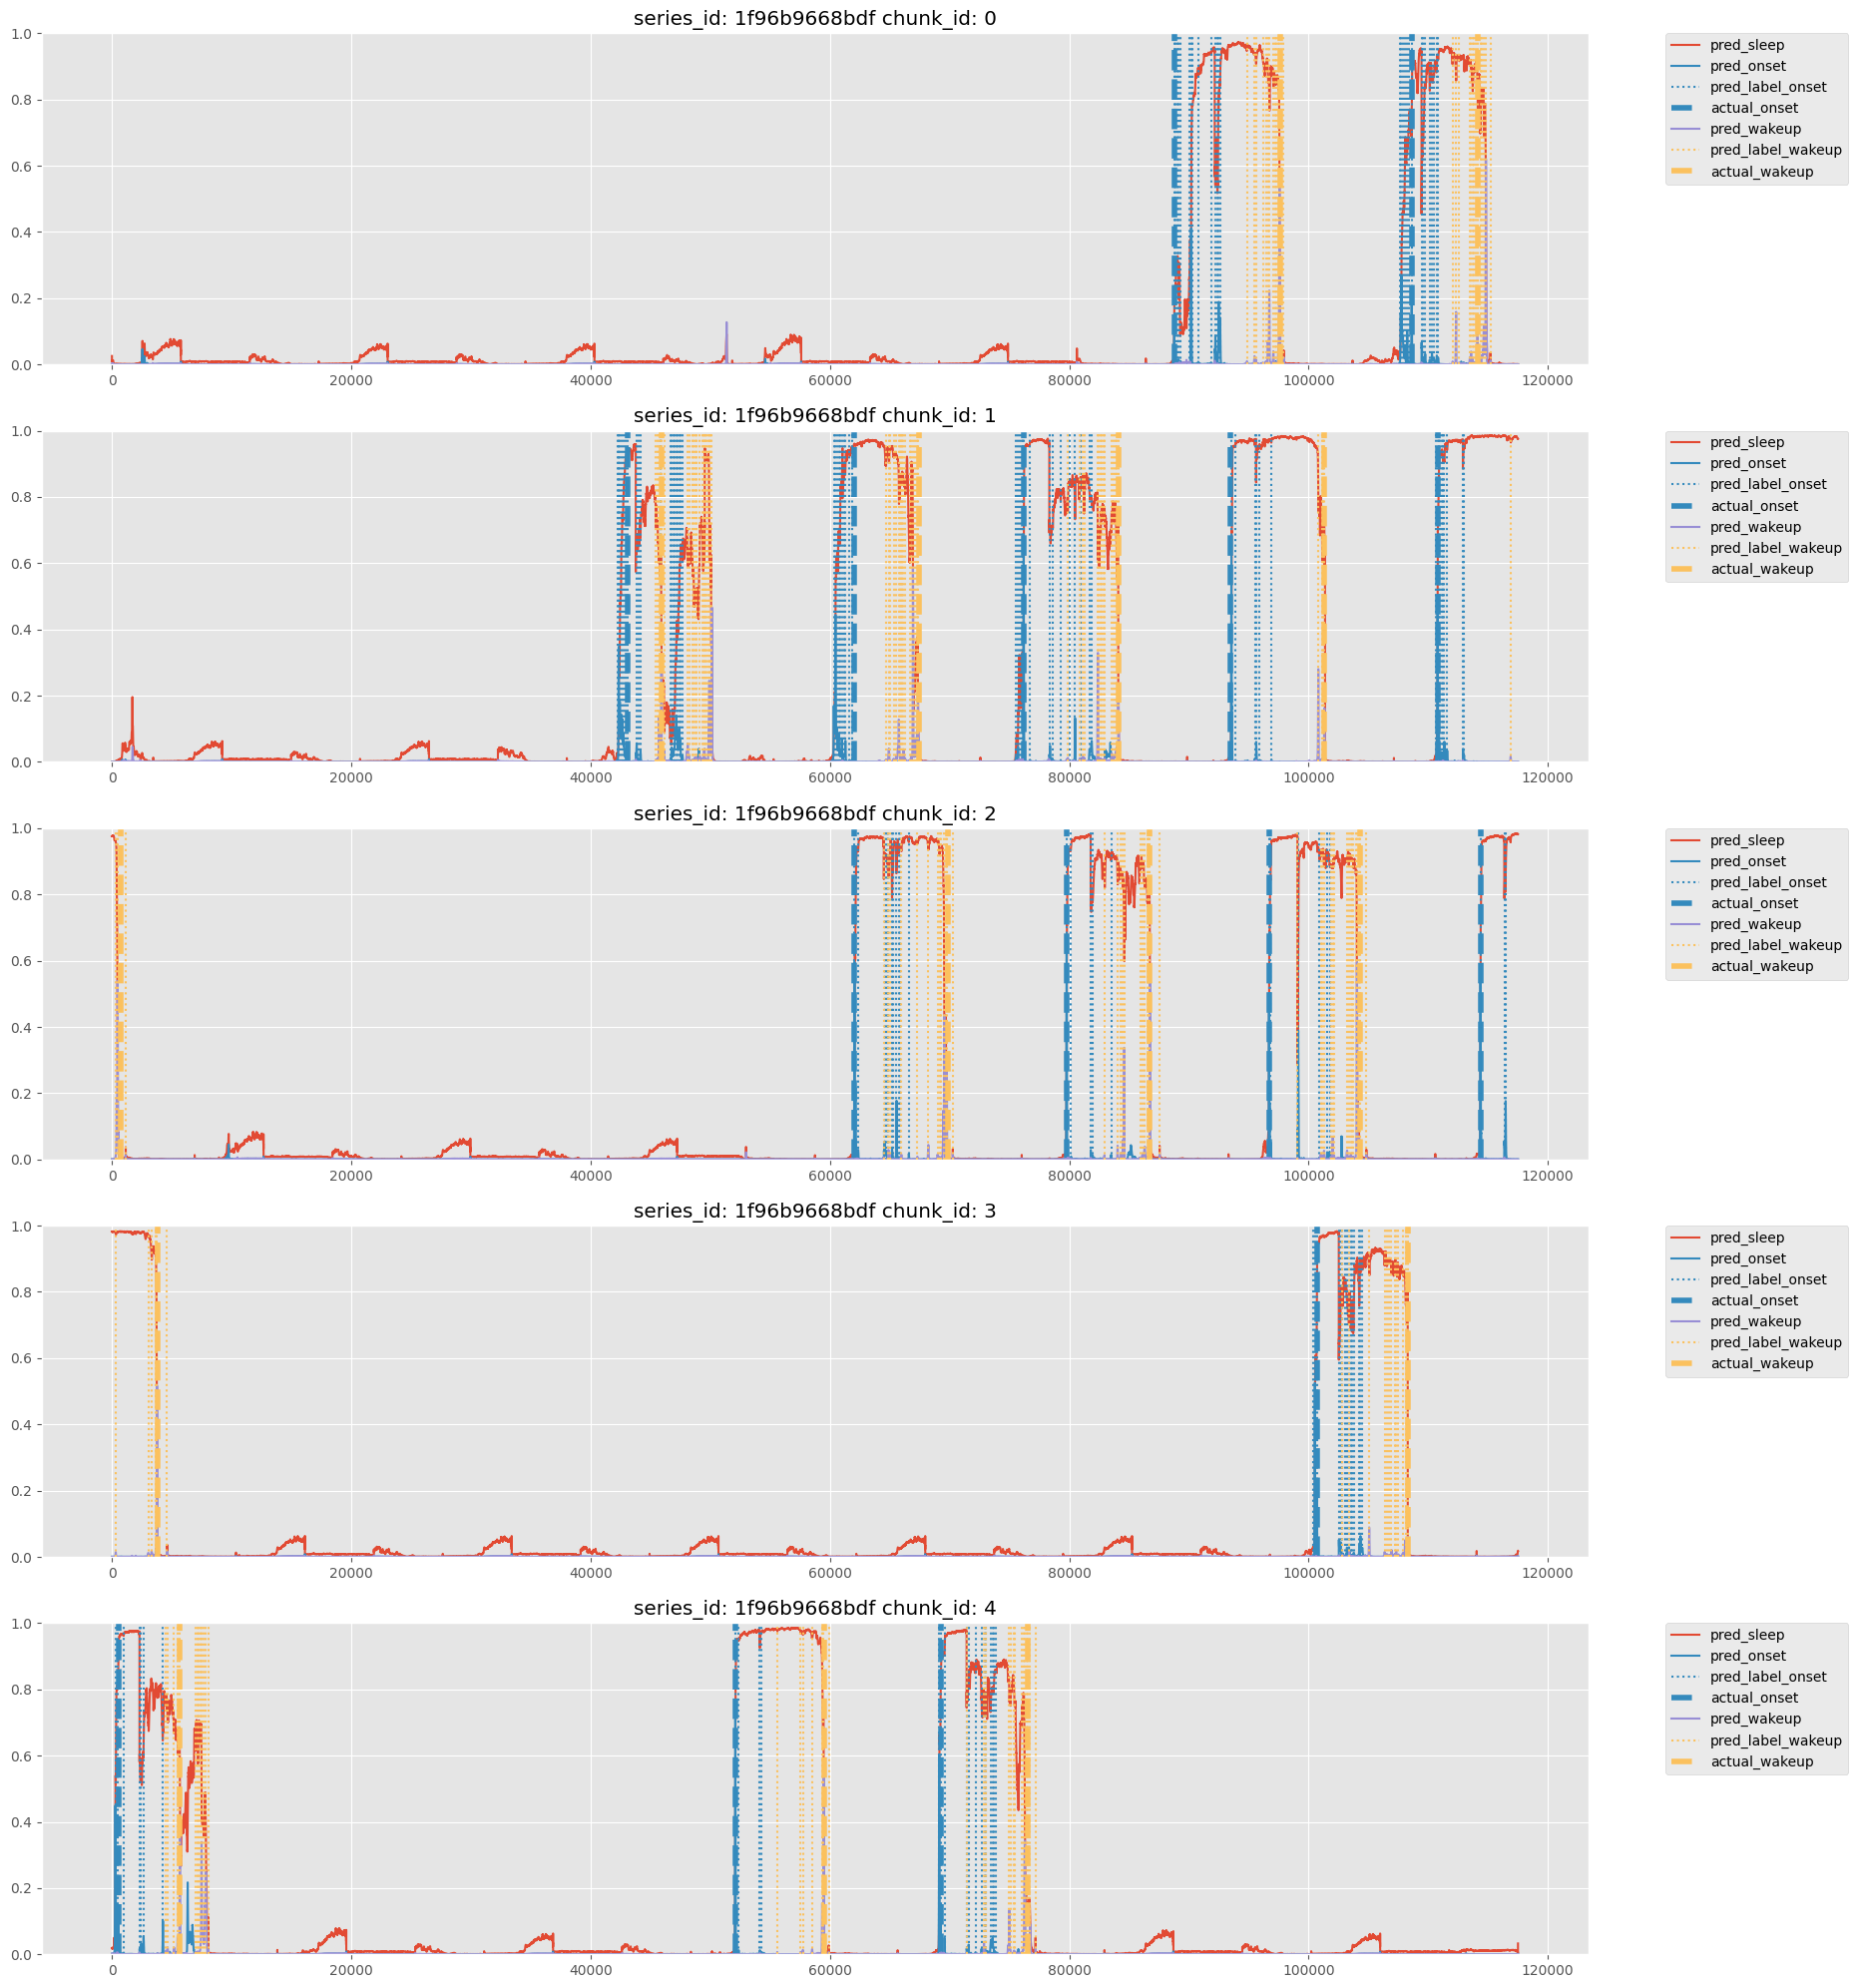

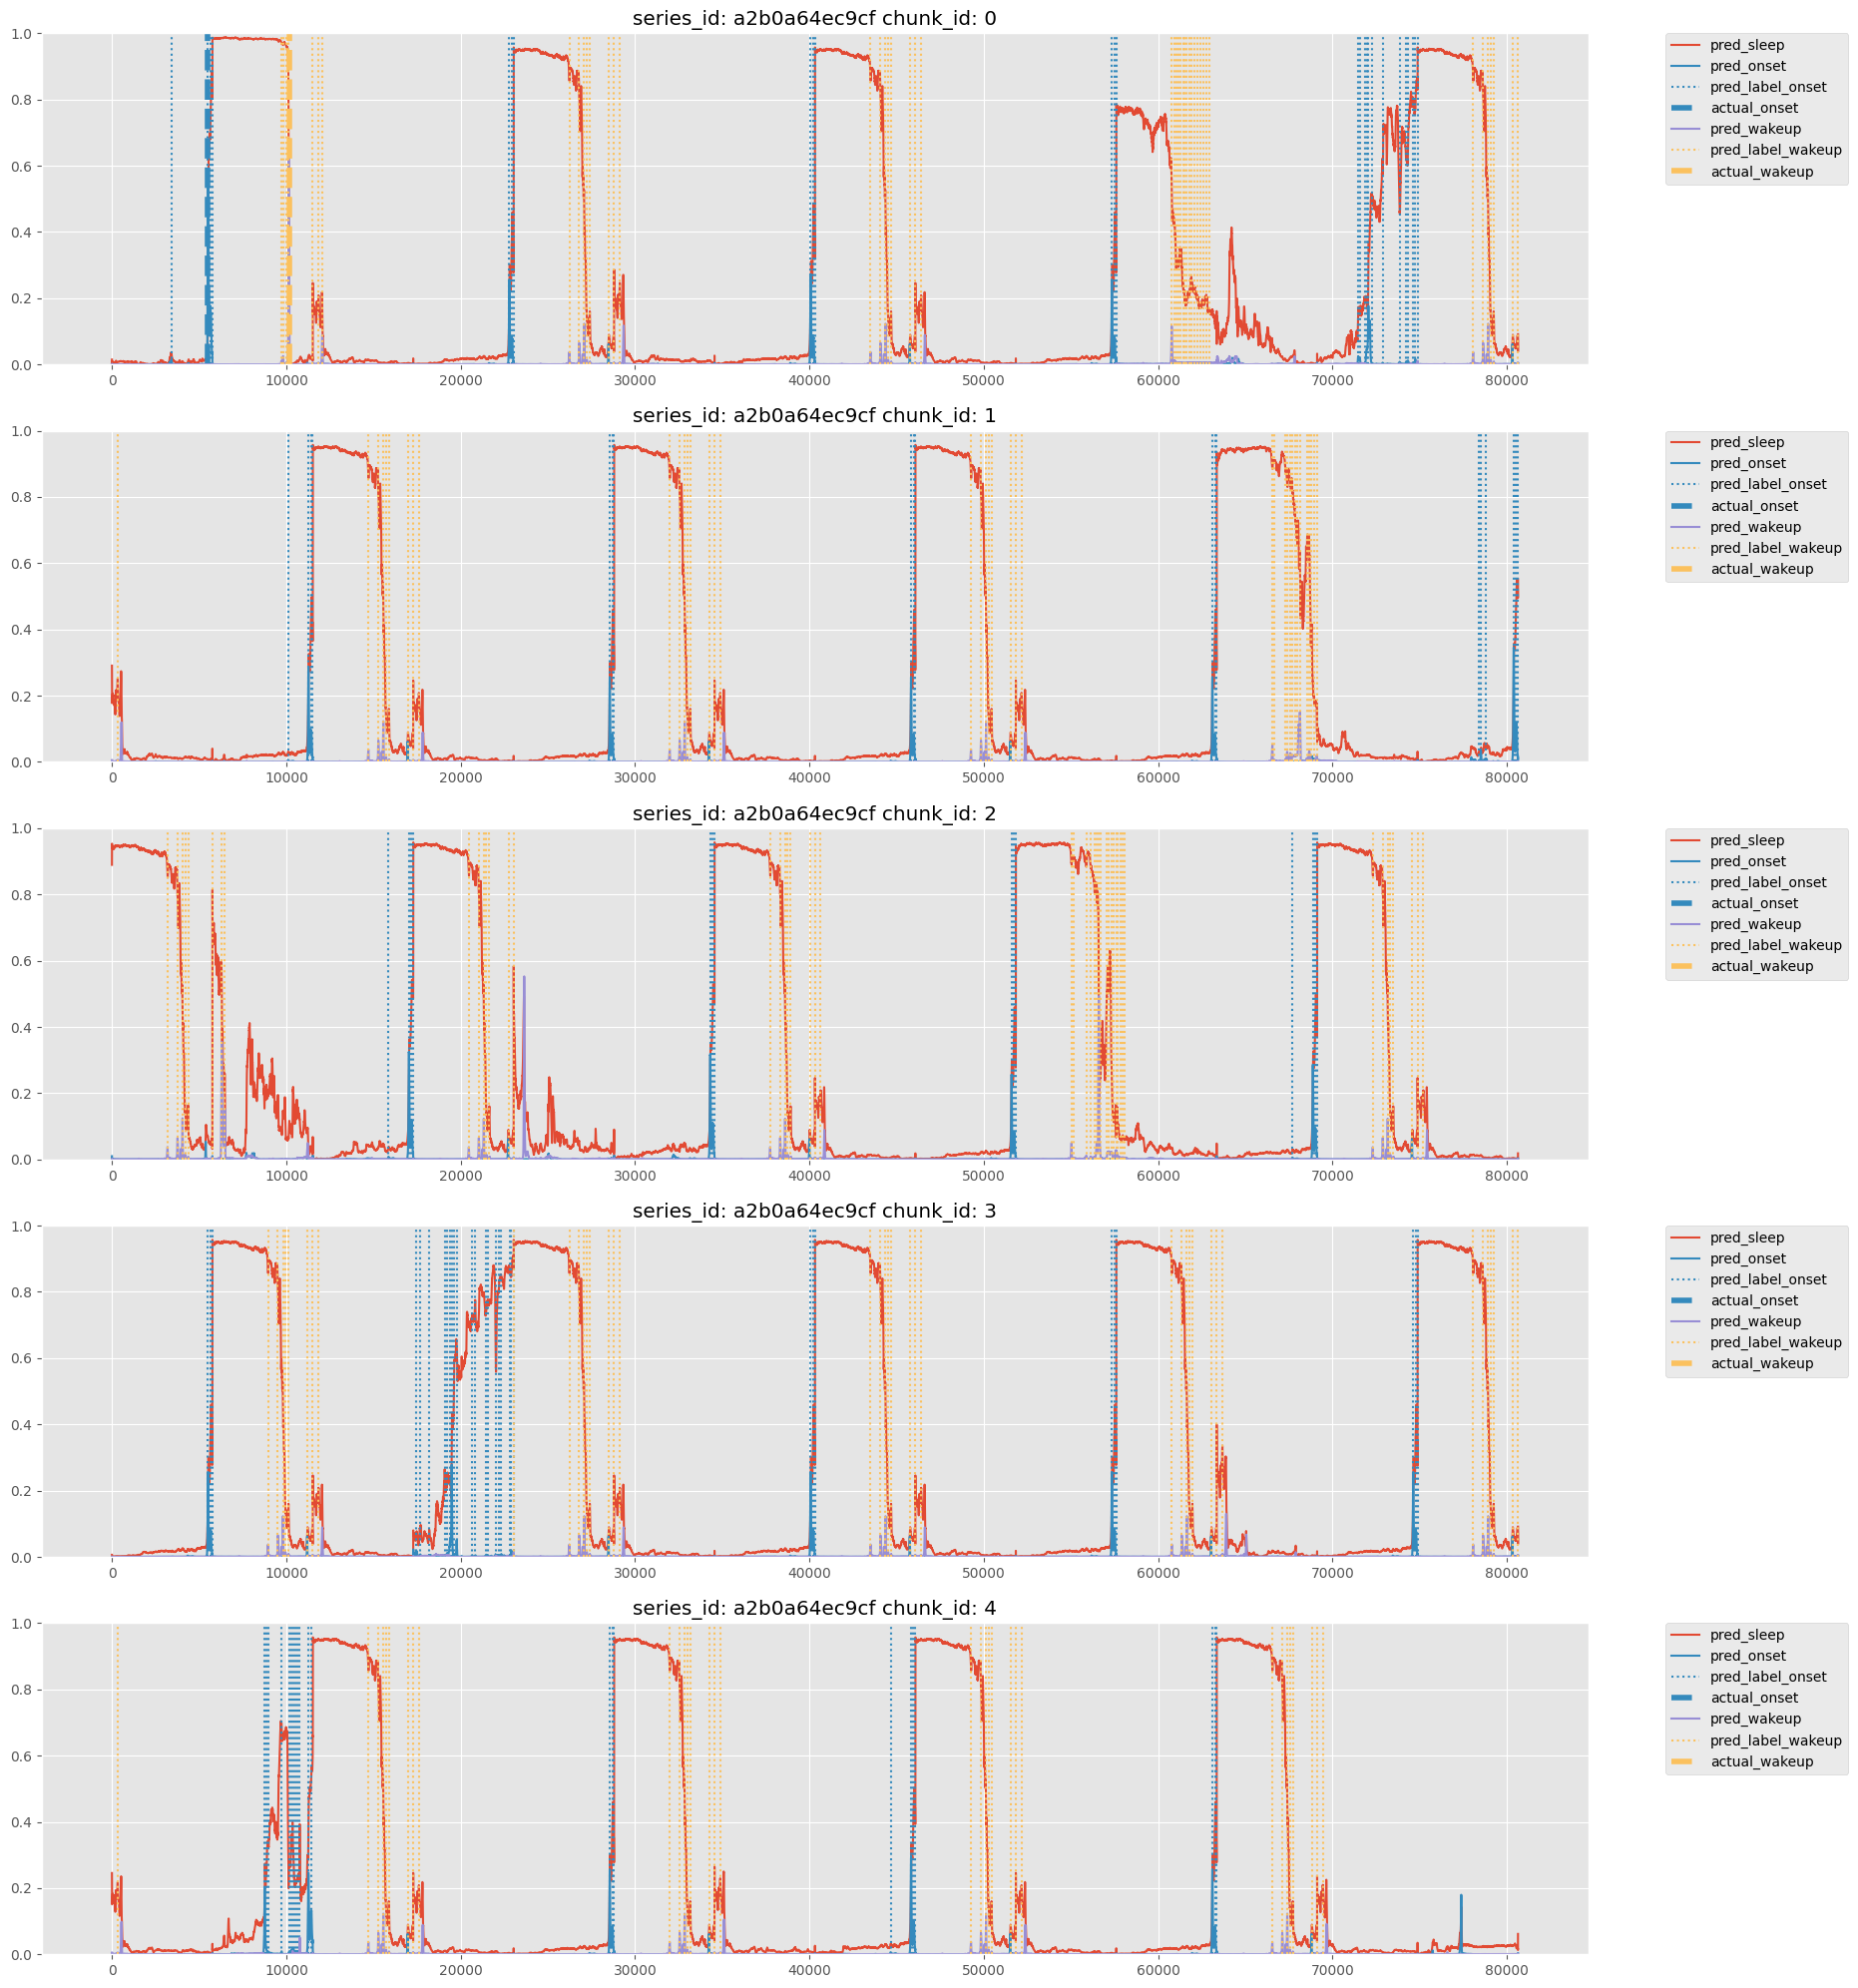

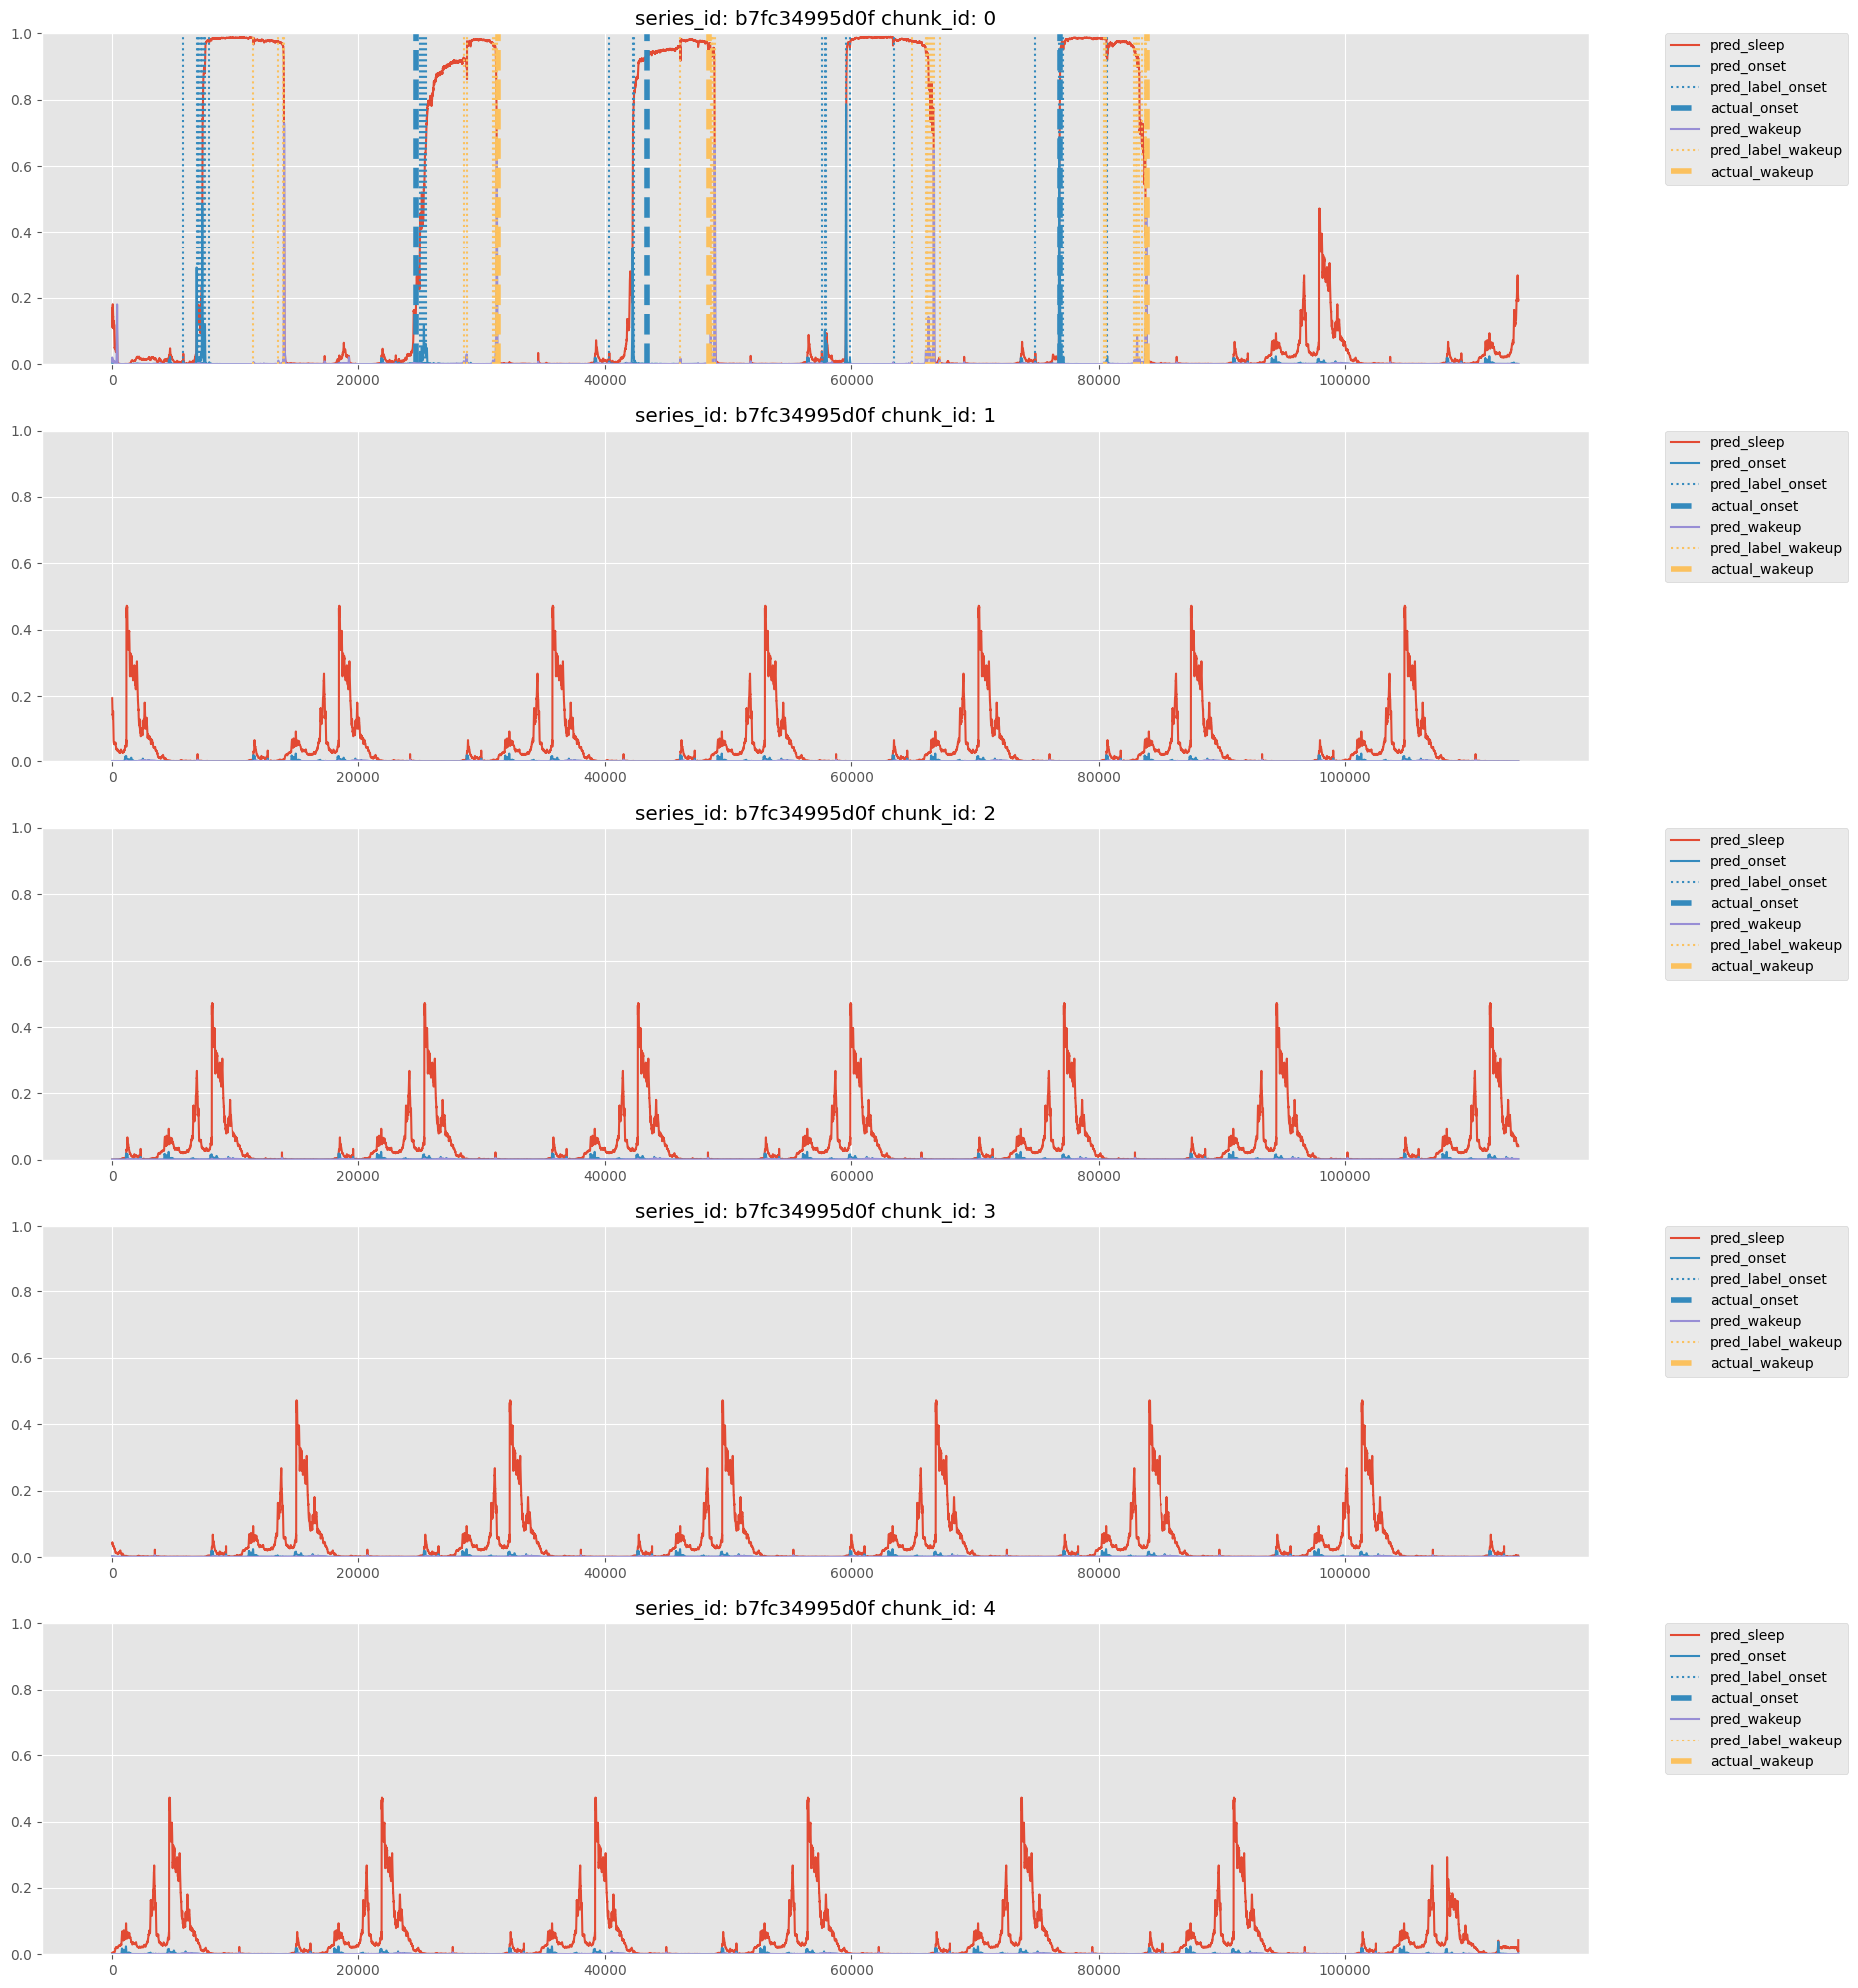

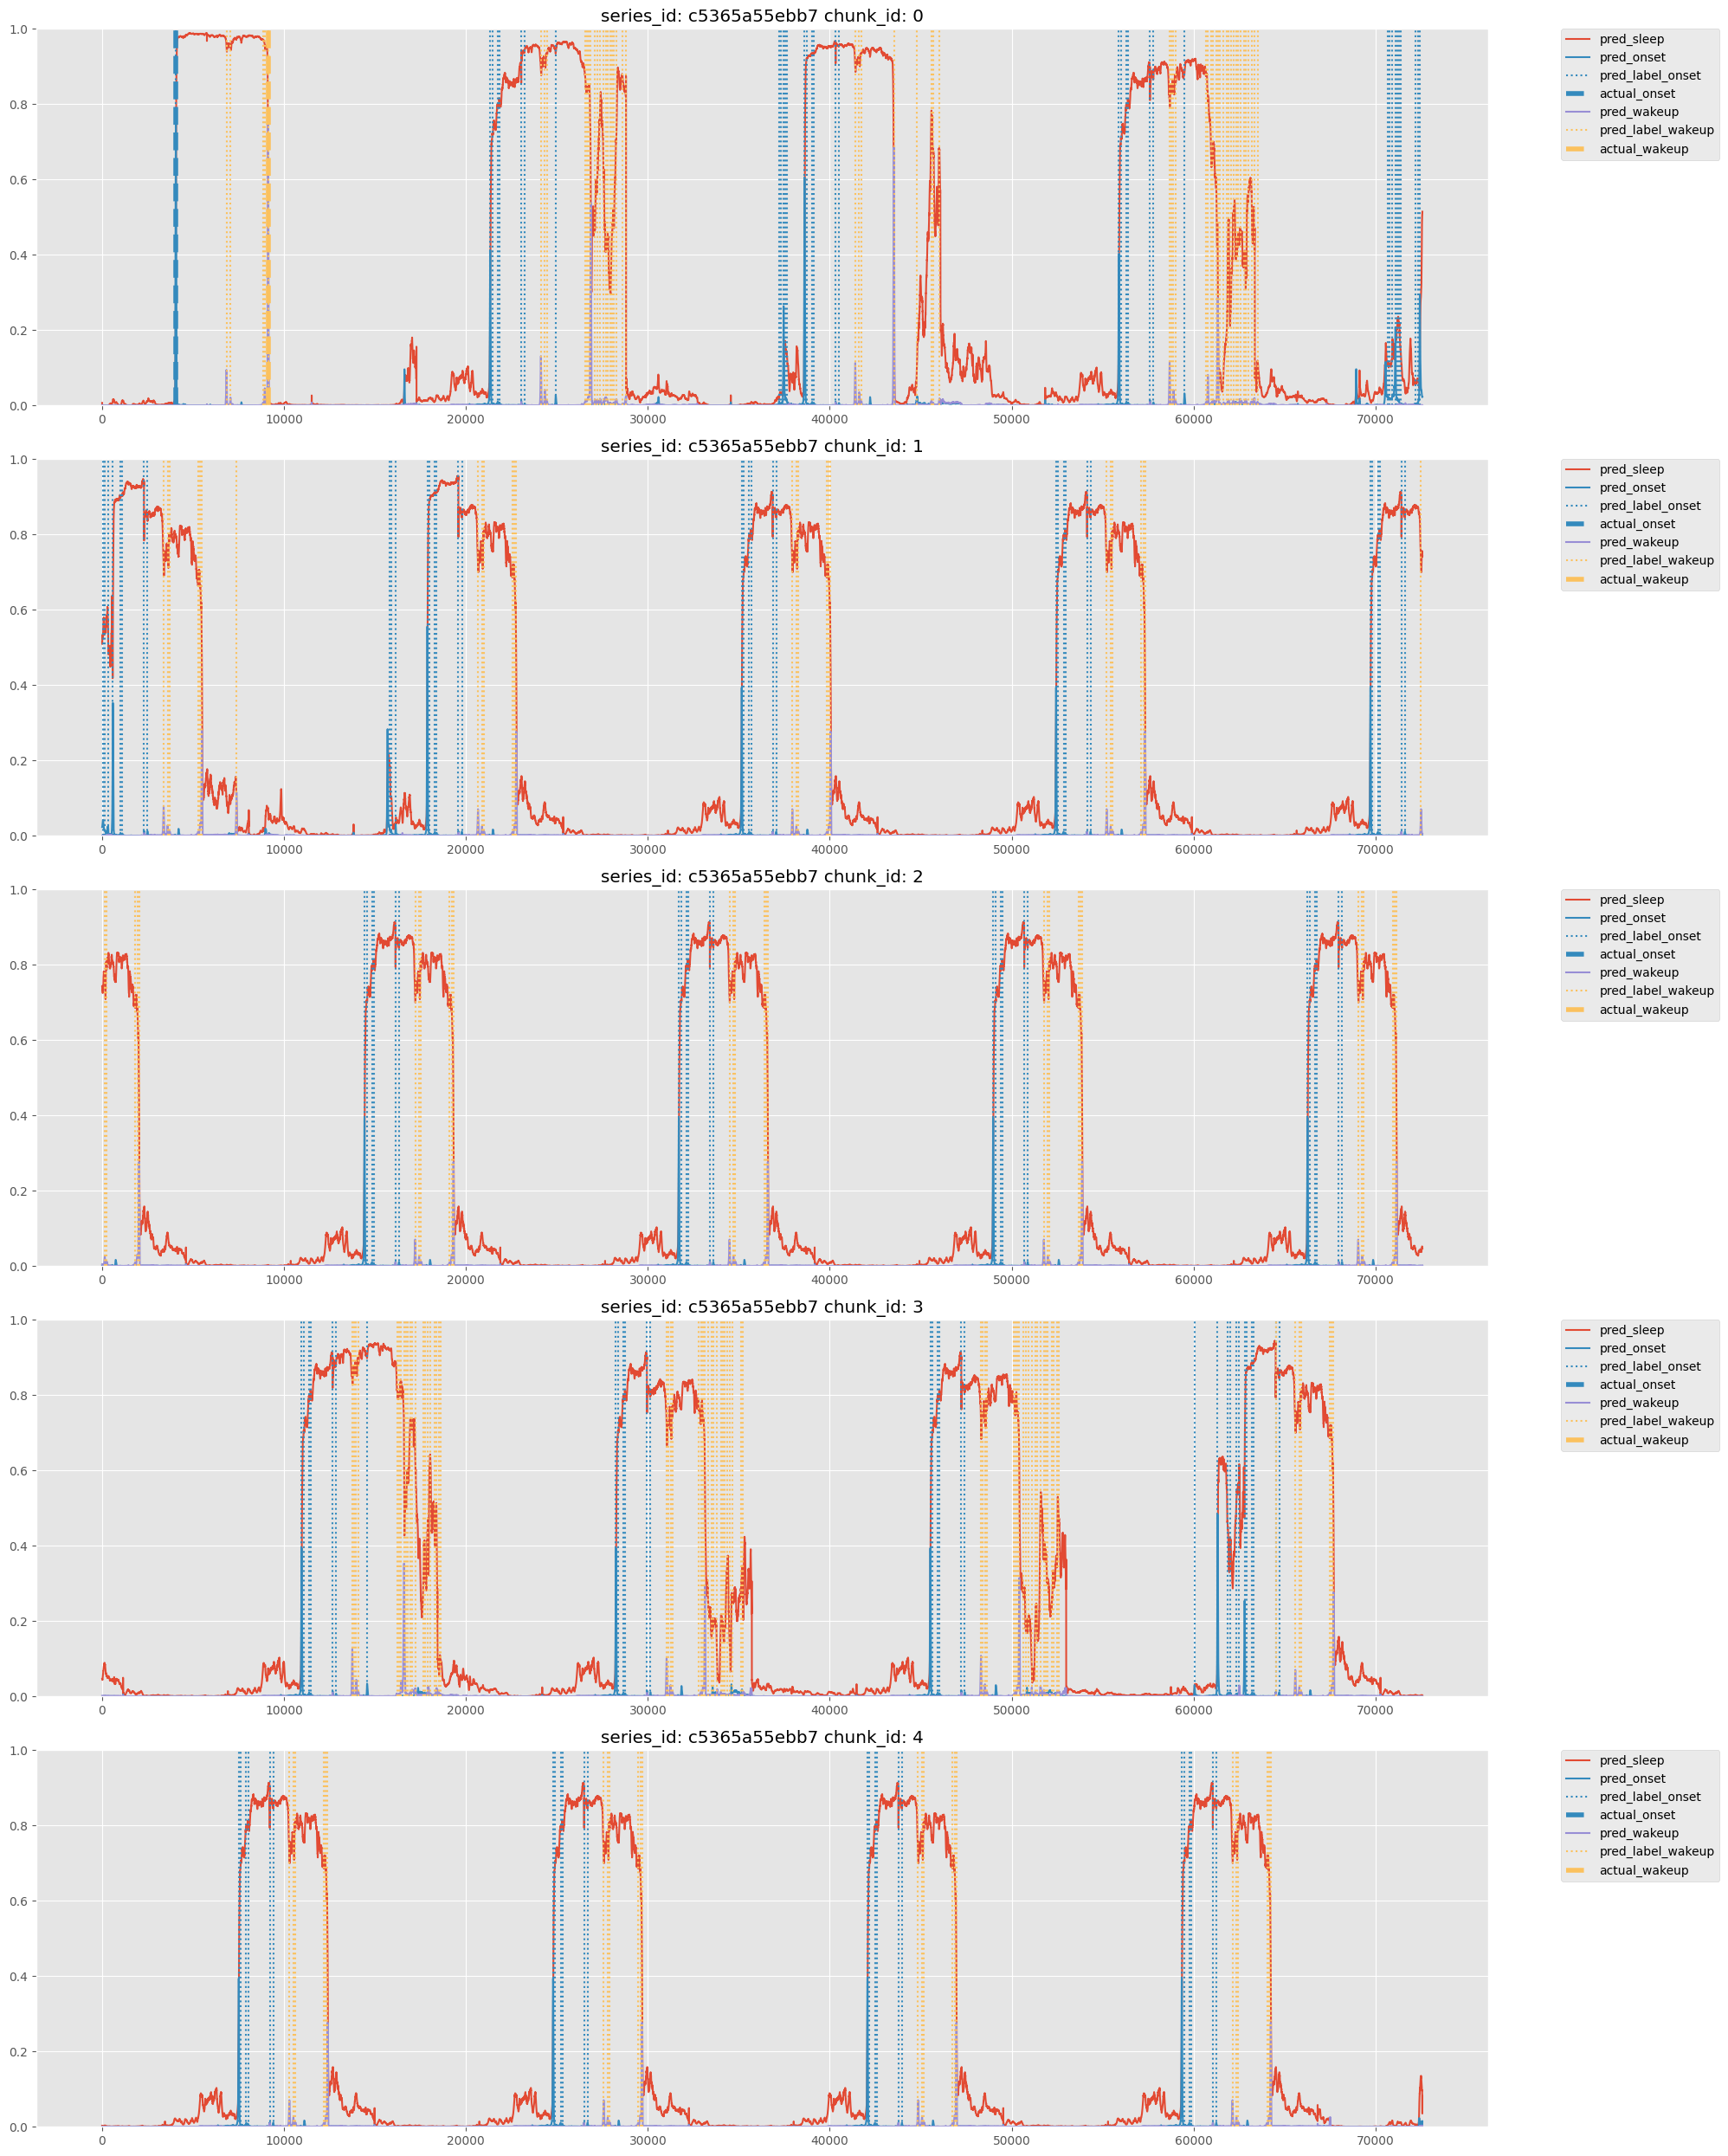

In [49]:

plot_random_sample(keys=keys,preds=preds,labels=labels,list_id = list_lowscore,df_submit=df_submit[df_submit["sleep_score"] > 0.5],mode = "all")

In [50]:
60*12*6

4320

In [51]:
df_submit[(df_submit["sleep_score"] > 0.5) & (df_submit["series_id"] == 'b7fc34995d0f')].sort_values("step",ascending=True).head(30)

,row_id,series_id,step,event,score,sleep_score
13585,13585,b7fc34995d0f,5759,onset,0.008744,0.979917
13586,13586,b7fc34995d0f,6836,onset,0.291367,0.985273
13587,13587,b7fc34995d0f,6945,onset,0.006069,0.985524
13588,13588,b7fc34995d0f,7065,onset,0.012021,0.985749
13589,13589,b7fc34995d0f,7184,onset,0.031311,0.985821
13590,13590,b7fc34995d0f,7289,onset,0.485598,0.985821
13591,13591,b7fc34995d0f,7400,onset,0.016264,0.985821
13592,13592,b7fc34995d0f,7509,onset,0.119444,0.985821
13593,13593,b7fc34995d0f,7864,onset,0.005885,0.985821
13594,13594,b7fc34995d0f,11519,wakeup,0.006345,0.985821


In [52]:
gt_df[gt_df["series_id"] == 'b7fc34995d0f'].sort_values(by = "step")

,series_id,night,event,step,timestamp
1344,b7fc34995d0f,2,onset,24636.0,2018-06-28T21:58:00-0400
1345,b7fc34995d0f,2,wakeup,31272.0,2018-06-29T07:11:00-0400
1346,b7fc34995d0f,3,onset,43368.0,2018-06-29T23:59:00-0400
1347,b7fc34995d0f,3,wakeup,48504.0,2018-06-30T07:07:00-0400
1348,b7fc34995d0f,5,onset,76836.0,2018-07-01T22:28:00-0400
1349,b7fc34995d0f,5,wakeup,83916.0,2018-07-02T08:18:00-0400
